In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from numpy.linalg import cholesky
from arch import arch_model

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 3)
plt.rcParams["axes.grid"] = False 
plt.rcParams["figure.dpi"] = 100  
#%matplotlib notebook

## Executive Summary

This notebook implements the conceptual “IRRBB” model using the following steps:
  - US Treasury data are mapped into curve factors → PCA factors (level, slope, curvature),
  - The factors are given time-series dynamics under $\mathbb{P}$ using AR(1)/OU and VAR dynamics,
  - The resulting shocks are pushed through to yield curves to determine the impacts on IRRBB metrics (NII/EVE),
  - The link betweeen discrete GARCH and continuous OU/Heston time-varying volatilities are shown, and finally
  - An out-of-sample backtesting is performed to assess forecasting performance.

The Backtests show that these parsimonious models have useful but modest
  forecasting skill: they capture broad rate trends but systematically
  under-react to sharp regime shifts (e.g. the 2022–2023 hiking cycle).
  They should therefore be used as a disciplined statistical **baseline**
  to be complemented by judgment and scenario overlays, rather than as
  stand-alone predictors.
  
### 1. Data and sanity checks

- UST par yields are loaded from `daily_UST.xlsx` across maturities
  (1Y, 2Y, 5Y, 10Y, 30Y) on a daily grid.
- Cross-sectional plots for early, mid-sample and recent dates show
  realistic curve shapes: low pre-COVID, very low in 2020, and much higher
  with evidence of flattening/inversion by 2025.
- Time-series plots of 2Y/10Y/30Y show the expected behaviour: a drop into
  2020 followed by sharp increases from 2022 onward, with front-end rates
  moving more than the long end.

These checks give confidence that the raw inputs are correct and economically
sensible.

### 2. PCA: level, slope, curvature factors

- PCA is applied to *changes* in par yields (across maturities).
- The first three principal components explain the bulk of the variance
  (roughly 80–85% for the level, 10–15% for the slope, and a few percentage for the curvature, respectively).
- The loading shapes have the textbook interpretation:
  - PC1: same sign across maturities → level.
  - PC2: short vs long opposite sign → slope.
  - PC3: hump-like shape → curvature.
- The factor time series are mean-zero, with PC1 showing the largest swings
  and clear spikes in known stress periods (e.g. 2020, 2022 tightening).

This section realises the “cross-section” part of the spine: a few factors
plus loadings summarise the entire yield curve.

### 3. AR(1) on 1Y and OU/Hull–White mapping

- An AR(1) is fitted to the 1Y yield:
  $$
    r_{t+1} = \alpha + \phi r_t + \varepsilon_{t+1},
  $$
  with $\phi$ very close to 1 and small daily noise, as expected.
- These parameters are mapped to continuous-time OU/Hull–White form:
  $$
    dr_t = \kappa(\theta - r_t)\,dt + \sigma\,dW_t,
  $$
  via the standard AR(1)–OU identification.
- One subtlety is the choice of time step $\Delta$: the notebook currently
  uses $\Delta=1$; interpreting the data as daily would imply
  $\Delta \approx 1/252$ and yields more realistic annualised $\kappa$ and
  $\sigma$.

This section demonstrates how a simple discrete-time AR(1) short-rate model can be
viewed as a discretised OU/HW process under $\mathbb{P}$.

### 4. VAR(1) on PCA factors and & 5.  SVAR-style shocks

- A VAR(1) is fitted to $(\mathrm{PC1}, \mathrm{PC2}, \mathrm{PC3})'$:
  $$
    b_{t+1} = c + \Phi b_t + u_{t+1},
  $$
  with generally small autoregressive coefficients, consistent with daily
  factor changes being close to white noise.

- The covariance matrix $\Sigma_u$ of the reduced-form shocks $u_t$ is
  estimated, and its Cholesky factor $B$ is used in
  $$
    u_t = B \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, I),
  $$
  as a simple “SVAR-style” structural decomposition.

- A one-unit shock to the first structural factor,
  $\varepsilon_0 = (1,0,0)'$, is propagated through the VAR and then mapped
  into a yield-curve move via the PCA loadings.

The resulting impulse curve looks like a predominantly level shift with some
slope and curvature, matching the intuition “structural factor shock →
yield-curve move” in the spine.

**Note on SVAR and missing macro data.**  
In a full macro SVAR scenario testing, the state vector would include a macro block
$z_t$ (e.g. output gap, inflation, policy rate) alongside the curve factors
$b_t$, and the columns of $B$ would be identified as economically interpretable
shocks (monetary policy, demand, risk-premium, etc.) using zero, sign or
long-run restrictions. In this notebook we only work with the PCA factors and
no explicit macro variables, so the Cholesky-based “structural” shocks are
*unnamed*: they are orthogonalised factor shocks rather than labelled
“monetary policy” or “demand” shocks. A true named SVAR experiment would
require adding macro time series to the VAR state and imposing an explicit
identification scheme on $B$.


### 6. IRRBB: EVE under a parallel shift

- A minimal balance sheet is set up with a 30Y asset and a shorter liability
  (e.g. 5Y), both discounted using a flat zero rate equal to the current
  10Y yield.
- Under a +100 bp parallel shift:
  - PV(asset) falls more than PV(liability),
  - EVE (asset PV minus liability PV) declines.
- This reproduces the textbook message: a long asset funded shorter loses
  economic value when rates rise.

This section binds curve shocks to a concrete EVE impact, preparing the
ground for more complex NII/EVE analyses.

### 7. Volatility: GARCH on PC1 and link to VAR–GARCH / Heston

- A GARCH(1,1) is fitted to PC1 (both with constant mean and with an AR(1)
  mean). In both cases, the estimated parameters satisfy
  $\alpha_1 + \beta_1 \approx 1$, indicating highly persistent but
  mean-reverting volatility.
- The conditional volatility $\sigma_t$ exhibits marked clustering, with
  spikes around crisis or tightening periods (e.g. 2020, 2022).
- This suggests a VAR–GARCH-style extension:
  $$
    b_{t+1} = c + \Phi b_t + H_{t+1}^{1/2} \varepsilon_{t+1},
  $$
  where $H_t$ follows a GARCH-type recursion, the discrete-time analogue of
  OU–Heston/CIR stochastic-volatility diffusions.

This section gives a concrete example of “volatility as its own state
variable” in discrete time, mirroring the continuous-time OU–Heston
discussion in the theory.

### 8. Backtesting: AR(1), VAR(1), Kalman filter

**AR(1) backtest on 1Y**

- We split the sample into 2016–2021 (estimation) and 2022–2025 (backtest). The estimation window covers a long low-rate environment (including the COVID period -- when policy rates e.g. Fed funds were at or very close to 0%), while the backtest window captures the sharp tightening cycle starting in 2022. This allows us to see how a simple AR/VAR model, fitted on “old-regime” data, behaves when confronted with an out-of-sample regime shift; precisely the type of question that matters for IRRBB and stress testing.
- AR(1) parameters are estimated on the training sample and used to produce
  one-step-ahead forecasts in the backtest window. 
- RMSE/MAE are modest, and plots show that the AR(1) broadly tracks the direction of rates but under-reacts to the sharp hiking cycle in 2022–2023, leading to clustered forecast errors in that period. This is typical for such parsimonious, single-equation models: richer specifications (e.g. factor VAR/SVAR with macro drivers, regime-switching short-rate models, or time-varying-parameter / Kalman-filter models) can capture breaks and nonlinearities better, at the cost of more complexity and parameter uncertainty.

**VAR(1) backtest on PCA factors**

- A similar split is applied to the factor VAR.
- PC1 shows a small amount of forecasting skill; PC2 and PC3 are close to
  white noise with little predictable structure.
- Residual diagnostics indicate some remaining cross-factor correlation,
  but overall the VAR behaves as expected for daily PCA factor changes.

**Kalman AR(1) backtest**

- The 1Y yield is re-cast in a 1D linear Gaussian state-space:
  $$
    x_{t+1} = \alpha + \phi x_t + w_t, \quad
    y_t = x_t + v_t,
  $$
  with $w_t$ and $v_t$ Gaussian noises.

- A simple **linear Gaussian Kalman filter** is implemented for a 1D AR(1)
  state-space model of the 1Y yield:
  $$
    x_{t+1} = \alpha + \phi x_t + w_t, \quad
    y_t = x_t + v_t.
  $$
  The filter produces filtered states and one-step-ahead forecasts.

- Out-of-sample RMSE/MAE are very close to those of the plain AR(1)
  backtest, which is exactly what we expect: the Kalman filter is an
  efficient estimation algorithm for a *given* linear-Gaussian model, not a
  different model with extra forecasting power.

- Additional benefits of the Kalman framework appear when we move beyond
  this simple setup: higher-dimensional factor states, missing data,
  time-varying parameters, or **nonlinear/non-Gaussian** specifications
  (extended/unscented Kalman filters, particle filters) for more realistic
  IRRBB use cases.

In this notebook we used the **linear** Kalman filter mainly as a transparent
implementation of a 1D AR(1) state-space. In more realistic IRRBB settings,
nonlinearity enters naturally:

- The **measurement equation** can be nonlinear: observed option prices,
  OAS, or prepayment rates are nonlinear functions of underlying curve
  factors and volatility states (e.g. Black/Heston pricing formulas, logistic
  links for prepayment/behavioural models).

- The **state dynamics** can be nonlinear: stochastic volatility (e.g. Heston
  style, where volatility enters as $\sqrt{v_t}$), time-varying parameters,
  or regime-switching rules for short rates.

In such cases, linear-Gaussian Kalman filtering is no longer adequate, and
one turns to **extended Kalman filters (EKF)**, **unscented Kalman filters
(UKF)** or **particle filters** to estimate the latent states (factors,
volatility, prepayment intensities) from noisy observations. The principle
remains the same, state-space plus filtering, but the nonlinear machinery is
needed to respect the actual economics of options, behaviour and volatility.

## 1. UST par yields: data structure and first look

We start from `daily_UST.xlsx`, which has one sheet per year (2016–2025) with
daily U.S. Treasury **par yields** by maturity (e.g. 1Y, 2Y, 5Y, 10Y, 30Y).
We:

1. Read all sheets and stack them into a single time series.
2. Sort by `Date` and set the date as the index.
3. Select a subset of key maturities, e.g.
   $
     \tau \in \{1, 2, 5, 10, 30\}\ \text{years}.
   $

Mathematically, after this step we have a panel
$
  y_t(\tau_i), \quad t=1,\dots,T,\; i=1,\dots,5,
$
where $y_t(\tau_i)$ is the par yield at date $t$ and maturity $\tau_i$.

**What we expect to see**

- The first few rows of `yields_df` should show reasonable levels (e.g. low
  rates around 2016–2020, higher post-2022).
- When we later plot:
  - cross-sections $t \mapsto y_t(\tau)$ for a few dates, we should see
    “normal” increasing yield curves or mildly inverted ones in recent years;
  - time series for 2Y/5Y/10Y/30Y, we should see rates dropping in 2020, then
    rising sharply from 2022 onward.


In [2]:
DATA_PATH = "daily_UST.xlsx"
xls = pd.ExcelFile(DATA_PATH)

# Parse and stack all yearly sheets
df_list = []
for sheet in xls.sheet_names:
    tmp = xls.parse(sheet)
    # Ensure Date is datetime
    tmp["Date"] = pd.to_datetime(tmp["Date"])
    df_list.append(tmp)

df_all = pd.concat(df_list, ignore_index=True)

# Sort by date and set index
df_all = df_all.sort_values("Date").set_index("Date")

# Inspect columns to confirm structure
print(df_all.columns)

# Choose a subset of maturities for the analysis
maturity_cols_raw = ["1 Yr", "2 Yr", "5 Yr", "10 Yr", "30 Yr"]

# Rename to nicer labels without spaces
rename_map = {"1 Yr": "1Y", "2 Yr": "2Y", "5 Yr": "5Y", "10 Yr": "10Y", "30 Yr": "30Y"}
yields_df = df_all[maturity_cols_raw].rename(columns=rename_map)

# Show the first few rows
yields_df.head()

print('tabs read are: ', xls.sheet_names)
print(f'i.e. from {df_all.index.min()} to {df_all.index.max()}, a total of {len(df_all)} rows')

Index(['1 Mo', '1.5 Month', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr',
       '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
      dtype='object')
tabs read are:  ['2025', '2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016']
i.e. from 2016-01-04 00:00:00 to 2025-11-06 00:00:00, a total of 2463 rows


### 1.1 Cross-sections and time series of par yields

Here we sanity-check the stacked dataset by plotting:

- **Cross-sections:** for a few sample dates $t_1, t_2, t_3$, we plot
  $\tau \mapsto y_{t_k}(\tau)$ across maturities
  $\tau \in \{1,2,5,10,30\}$.
- **Time series:** we plot $t \mapsto y_t(\tau)$ for a few maturities
  (e.g. 2Y, 5Y, 10Y, 30Y).

**What we expect to see**

- Cross-sections: smooth curves that are:
  - mostly upward sloping in “normal” periods;
  - possibly flatter or inverted in recent years (e.g. 2Y > 10Y).
- Time series:
  - low rates in the late 2010s,
  - a sharp drop around early 2020,
  - a strong rise from 2022 as central banks tightened.


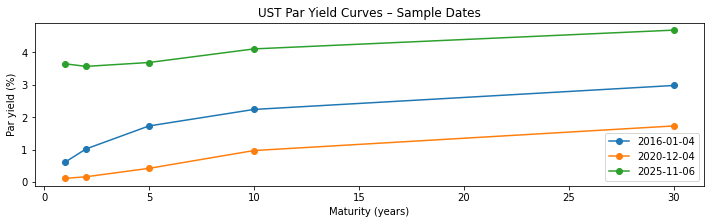

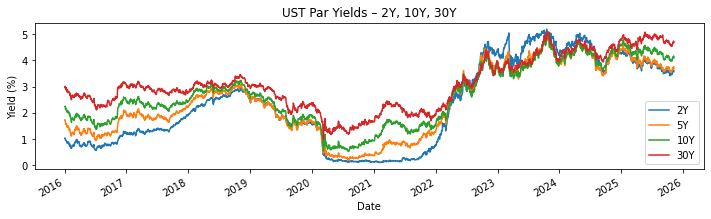

In [3]:
# Plot a couple of cross-sections
example_dates = yields_df.index[[0, len(yields_df)//2, -1]]
taus = np.array([1, 2, 5, 10, 30])
maturity_cols = ["1Y", "2Y", "5Y", "10Y", "30Y"]

plt.figure(figsize=(12,3))
for d in example_dates:
    plt.plot(taus, yields_df.loc[d, maturity_cols].values, marker="o", label=str(d.date()))
plt.xlabel("Maturity (years)")
plt.ylabel("Par yield (%)")
plt.title("UST Par Yield Curves – Sample Dates")
plt.legend()
plt.show()

# Time series of a few key maturities 
yields_df[["2Y", "5Y", "10Y", "30Y"]].plot(figsize=(12,3))
plt.title("UST Par Yields – 2Y, 10Y, 30Y")
plt.ylabel("Yield (%)")
plt.show()

## 2. PCA on yield changes: level, slope, curvature

We now extract **PCA factors** from daily changes in par yields. For each date
\(t\) and maturity \(\tau_i\), we form the change
$
  \Delta y_t(\tau_i) = y_t(\tau_i) - y_{t-1}(\tau_i).
$

Stacking across maturities, each day gives a vector
$
  \Delta y_t =
  \begin{bmatrix}
    \Delta y_t(\tau_1) \\
    \vdots \\
    \Delta y_t(\tau_5)
  \end{bmatrix}
  \in \mathbb{R}^5.
$

We run PCA on the matrix of changes $\{\Delta y_t\}_{t=2}^T$ and keep the
first 3 components, which yields:

- **Loadings** $\phi_m(\tau_i)$: how factor $m$ loads on maturity $\tau_i$.
- **Factor scores** $b_{m,t}$: time series of factor $m$ at date $t$.

The PCA representation of yield changes is
$
  \Delta y_t(\tau_i) \approx \sum_{m=1}^3 b_{m,t}\,\phi_m(\tau_i).
$

**What we expect to see**

- The explained variance ratios should look like
  “classic yield curve PCA”: roughly
  $ \text{PC1} \approx 70\text{–}90\%,\ \text{PC2} \approx 10\text{–}20\%,\ \text{PC3} \approx \text{single digits}$.
- This matches the standard **level / slope / curvature** story.


In [4]:
# Compute daily changes
dY = yields_df.diff().dropna()

# Run PCA with 3 components
pca = PCA(n_components=3)
pca.fit(dY.values)

loadings = pca.components_  # shape: (3, n_maturities)
explained_var = pca.explained_variance_ratio_

print("Explained variance ratios:", explained_var)

# Factor scores (time series of factors)
factors = pca.transform(dY.values)  # shape: (T-1, 3)
factors_df = pd.DataFrame(
    factors,
    index=dY.index,
    columns=["PC1", "PC2", "PC3"]
)
factors_df.head()

Explained variance ratios: [0.82430576 0.13113424 0.02911349]


,PC1,PC2,PC3
Date,,,
2016-01-05,-0.046197,-0.024656,0.057196
2016-01-06,0.133688,-0.031836,0.017497
2016-01-07,0.058110,0.003522,0.011476
2016-01-08,0.057324,0.006740,0.005624
2016-01-11,-0.040556,0.049034,0.005617


***
### 2.1 PCA loadings and factor time series

We plot:

1. **PCA loadings** $\tau \mapsto \phi_m(\tau)$ for $m=1,2,3$.
2. **PCA factor series** $t \mapsto b_{m,t}$ for $m=1,2,3$.

**Interpretation and expected shapes**

- **PC1 (level):** loadings are all the same sign and similar magnitude
  across maturities → a **parallel shift** of the curve.
- **PC2 (slope):** loadings are positive at short maturities, negative at
  long (or vice versa) → a **steepening/flattening** tilt.
- **PC3 (curvature):** loadings are small at very short/very long ends and
  larger in the middle → a **hump** around mid-maturities.

For the time series:

- Each PC series $b_{m,t}$ should be roughly mean-zero (because we used
  changes) with spikes around macro/market stress periods (e.g. 2020–2022).
- PC1 typically has the largest swings; PC2 and PC3 are smaller but still
  show persistent episodes of higher volatility.


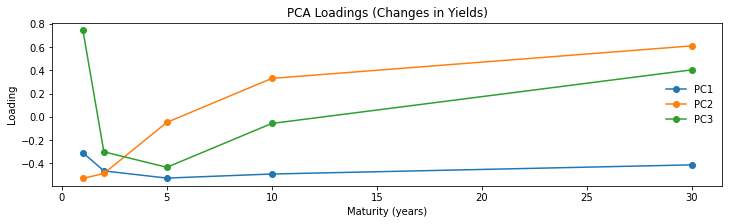

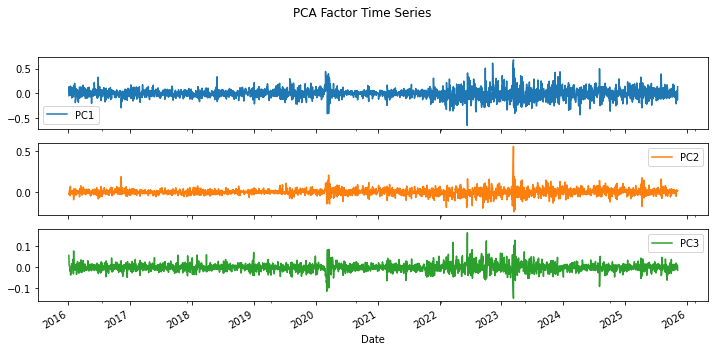

In [5]:
plt.figure(figsize=(12,3))
for i, name in enumerate(["PC1", "PC2", "PC3"]):
    plt.plot(taus, loadings[i, :], marker="o", label=name)
plt.xlabel("Maturity (years)")
plt.ylabel("Loading")
plt.title("PCA Loadings (Changes in Yields)")
plt.legend(frameon=False)
plt.show()

# Plot factor time series 
factors_df[["PC1", "PC2", "PC3"]].plot(subplots=True, figsize=(12,5), layout=(3,1), sharex=True)
plt.suptitle("PCA Factor Time Series", y=1.02)
plt.show()

## 3. Estimation under $\mathbb{P}$: AR(1) short rate and OU mapping

We treat the 1Y par yield as a **short-rate proxy** $r_t$ and fit a simple
AR(1) model under the real-world measure $\mathbb{P}$:
$$
  r_{t+1} = \alpha + \phi\,r_t + \varepsilon_{t+1}, \qquad
  \varepsilon_{t+1} \sim N(0,\sigma_\varepsilon^2).
$$

In [6]:
r = yields_df["1Y"].dropna()
# Build lagged data for AR(1): r_{t+1} on r_t
r_lag = r.shift(1).dropna()
y = r.loc[r_lag.index]          # r_{t+1}
X = sm.add_constant(r_lag)      # [1, r_t]

ols_model = sm.OLS(y, X)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                     1Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.483e+06
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:39:04   Log-Likelihood:                 4318.0
No. Observations:                2462   AIC:                            -8632.
Df Residuals:                    2460   BIC:                            -8620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.463      0.1

---
Now we can estimate $\alpha, \phi$ and $\sigma_\varepsilon$ by OLS:

In [7]:
alpha = ols_res.params["const"]
phi = ols_res.params[r.name]    # typically "1Y"
sigma_eps = ols_res.resid.std(ddof=1)

In [8]:
print("AR(1) parameters:")
print(f"alpha = {alpha:.4f}, phi = {phi:.4f}, sigma_eps = {sigma_eps:.4f}") 

AR(1) parameters:
alpha = 0.0020, phi = 0.9997, sigma_eps = 0.0419


---
Then we map these discrete-time parameters to a continuous-time **Ornstein–Uhlenbeck / Hull–White 1-factor** process:
$$
  dr_t = \kappa(\theta - r_t)\,dt + \sigma\,dW_t.
$$
For step size $\Delta t$ (in years), the implied relationships based on AR(1) estimates are:
$$
  \phi = e^{-\kappa \Delta t}  \rightarrow  \kappa = -\frac{\ln \phi}{\Delta t} \qquad
  \alpha = \theta(1-\phi) \rightarrow \theta = \frac{\alpha}{1-\phi} \qquad
  \sigma_\varepsilon^2
    = \sigma^2 \frac{1-e^{-2\kappa\Delta t}}{2\kappa} 
  \rightarrow
  \sigma = \sigma_\varepsilon
           \sqrt{\frac{2\kappa}{1-e^{-2\kappa\Delta t}}}
$$

In [9]:
delta = 1.0  # assume yearly spacing (adjust if r_t is not annual)
kappa = -np.log(phi) / delta
theta = alpha / (1 - phi)
sigma = sigma_eps * np.sqrt(2 * kappa / (1 - np.exp(-2 * kappa * delta)))

print("OU/HW parameters under P:")
print(f"kappa = {kappa:.4f}, theta = {theta:.4f}, sigma = {sigma:.4f}")

OU/HW parameters under P:
kappa = 0.0003, theta = 5.9503, sigma = 0.0419


---
**Supporting Notes:**

- The AR(1) fit on **daily** yields usually gives:
  - $\phi$ very close to 1 (strong persistence),
  - small residual standard deviation $\sigma_\varepsilon$,
  - a constant term $\alpha$ implying some long-run mean.
- If we set $\Delta t$ to one day (≈1/252 of a year), we should get:
  - a moderate annual mean reversion $\kappa$ (a few % per year),
  - a long-run mean $\theta$ roughly in the mid-range of observed rates,
  - a volatility $\sigma$ consistent with daily movements scaled to annual.


---
## 4. Estimation under $\mathbb{P}$: VAR(1) on PCA factors

We gather the three PCA factors into a vector
$$
  b_t = 
  \begin{bmatrix}
    b_{1,t} \\
    b_{2,t} \\
    b_{3,t}
  \end{bmatrix}
$$
and fit a **VAR(1)** under $\mathbb{P}$:
$$
  b_{t+1} = c + \Phi b_t + u_{t+1}, \qquad
  u_{t+1} \sim N(0,\Sigma_u).
$$
Here:
- $c$ is a 3-vector of intercepts,
- $\Phi$ is a $3\times 3$ coefficient matrix,
- $\Sigma_u$ is the covariance of the reduced-form shocks $u_t$.

**What we expect to see**

- Because the underlying data are **daily changes**, the factors are often
  close to white noise:
  - coefficients in $\Phi$ should be small and often not strongly
    significant,
  - residuals $u_t$ should be roughly uncorrelated over time.
- $\Sigma_u$ should be **almost diagonal**, because PCA factors are
  orthogonal by construction (any off-diagonal residual correlation comes
  from finite-sample effects or mild deviations from Gaussianity).


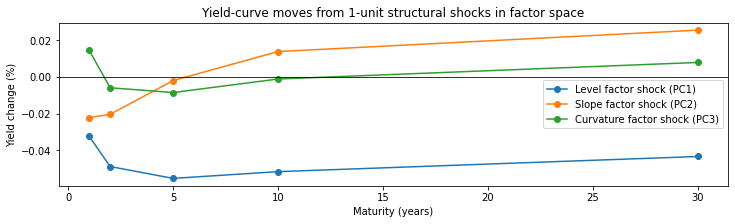

In [10]:
# For a factor (statistical only) shocks we need the 3 PCA's:

B = factors_df[["PC1", "PC2", "PC3"]].dropna().copy()
B.index = pd.RangeIndex(len(B))  
var_model = VAR(B)

var_res = var_model.fit(1)
Sigma_u = var_res.sigma_u

# Cholesky-based structural matrix
B_svar = cholesky(Sigma_u)

# Name the structural shocks in factor space
shock_names = {
    0: "Level factor shock (PC1)",
    1: "Slope factor shock (PC2)",
    2: "Curvature factor shock (PC3)",
}

def yield_impulse_from_factor_shock(shock_index, size=1.0):
    """
    One-step yield-curve response to a structural shock in factor space.
    shock_index: 0, 1, or 2 corresponding to PC1, PC2, PC3.
    size: size of the structural shock (in standard deviations).
    """
    n_shocks = B.shape[1]  # 3
    eps0 = np.zeros(n_shocks)
    eps0[shock_index] = size

    # Reduced-form shock u0
    u0 = B_svar @ eps0

    # Steady-state (baseline) factor vector
    b_ss = B.mean().values

    # VAR(1) parameters: intercept and Phi
    c = var_res.params.iloc[0].values          # shape (3,)
    Phi = var_res.params.iloc[1:].values       # shape (3, 3)

    # One-step response
    b1 = c + Phi @ b_ss + u0
    delta_b = b1 - b_ss                        # 3-vector

    # Map to yield changes: delta_y(τ) = sum_m delta_b_m * loading_m(τ)
    # Ensure `loadings` has shape (3, n_maturities)
    delta_y = delta_b @ loadings               # shape (n_maturities,)

    return delta_y

# Example: plot responses for each named factor shock
plt.figure(figsize=(12,3))
for idx in range(3):
    dy = yield_impulse_from_factor_shock(idx, size=1.0)
    plt.plot(taus, dy, marker="o", label=shock_names[idx])

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Maturity (years)")
plt.ylabel("Yield change (%)")
plt.title("Yield-curve moves from 1-unit structural shocks in factor space")
plt.legend()
plt.show()

In [11]:
# However to incorporate macro shocks, we also need named macros series such as: policy rate, inflation, output gap
if False:
    X = pd.concat([macro_df[["policy_rate", "inflation", "output_gap"]],
                   factors_df[["PC1", "PC2", "PC3"]],], axis=1,).dropna()
    # then proceed as before 
    var_model = VAR(X)
    var_res = var_model.fit(1)
    print(var_res.summary())
    Sigma_u = var_res.sigma_u
    B_svar = cholesky(Sigma_u)

# This part is kind of a template and therefore not executed until we have the macro data

## 5. Structural (SVAR-style) shocks and yield-curve response

The VAR gives us **reduced-form** shocks $u_t$ with covariance $\Sigma_u$.
We define **structural shocks** $\varepsilon_t$ via
$$
  u_t = B\,\varepsilon_t, \qquad
  \varepsilon_t \sim N(0, I_3),
$$
and choose $B$ as the **Cholesky factor** of $\Sigma_u$:
$
  \Sigma_u = B B'.
$

We then:

1. Take a baseline factor level $b_{\text{ss}}$ (e.g. sample mean).
2. Apply a one-unit structural shock
   $\varepsilon_0 = (1, 0, 0)'$ at time 0:
   $
     u_0 = B\,\varepsilon_0.
   $
3. Compute the one-step response of the factors:
   $
     b_1 = c + \Phi b_{\text{ss}} + u_0.
   $
4. Look at the factor change $\Delta b = b_1 - b_{\text{ss}}$ and map it
   back to a yield-curve move using the PCA loadings:
   $
     \Delta y(\tau_i) \approx \sum_{m=1}^3 \Delta b_m\,\phi_m(\tau_i).
   $

In [12]:
# Cholesky factor as a simple structural matrix B
B_svar = cholesky(Sigma_u)
B_svar

# One-step impulse: epsilon = [1, 0, 0]'
eps0 = np.array([1.0, 0.0, 0.0])
u0 = B_svar @ eps0  # reduced-form shock

# Assume steady-state baseline factor (approx. long-run mean)
b_ss = B.mean().values

# One-step response in factors
b1 = var_res.params.iloc[0].values + var_res.params.iloc[1:].values @ b_ss + u0

# Map factor change to yield change:
# delta_y(τ) ≈ sum_m (b1_m - b_ss_m) * loading_m(τ)
delta_b = b1 - b_ss  # 3-vector
delta_y = delta_b @ loadings  # shape: (n_maturities,)

---
**What we expect to see**

- The resulting $\Delta y(\tau)$ plot should look like a **combination of
  level, slope and curvature**:
  - often dominated by a level-like shift with some tilt and hump,
  - its exact shape depends on the Cholesky ordering (which factor is “first”).
- This is a concrete example of the “macro/structural shock → factor shock
  → yield-curve move” mechanism in the IRRBB spine.

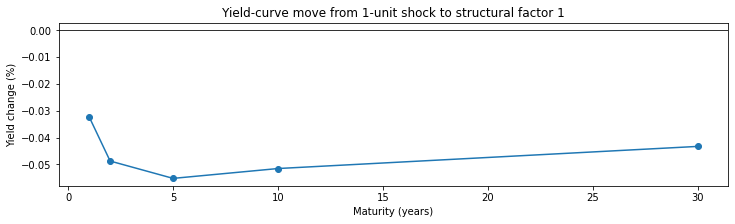

In [13]:
plt.figure(figsize=(12,3))
plt.plot(taus, delta_y, marker="o")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Maturity (years)")
plt.ylabel("Yield change (%)")
plt.title("Yield-curve move from 1-unit shock to structural factor 1")
plt.show()

## 6. IRRBB example: EVE under a parallel rate shock

We build a minimal toy banking book:

- **Asset:** 30-year fixed-rate loan, coupon $c_A = 5\%$, notional 100,
  annual payments.
- **Liability:** 5-year fixed-rate funding, coupon $c_L = 3\%$,
  notional 100, annual payments.

We approximate today’s discount curve with a **flat zero rate** equal to the
current 10Y par yield, say $z$. The discount factor is:
$
  P(0,T) = e^{-zT}.
$

The PV of a fixed-rate bullet (coupon $c$, maturity $N$ years, notional $N_0$) is
$$
  PV(c,N; z)
  = \sum_{t=1}^{N-1} cN_0\,e^{-z t}
    + (cN_0 + N_0)\,e^{-z N}.
$$

We compute:

- Baseline:
  $$
    PV_A^0 = PV(0.05, 30; z), \quad
    PV_L^0 = PV(0.03, 5; z), \quad
    EVE_0 = PV_A^0 - PV_L^0.
  $$
- Shocked (+100bp):
  $$
    z' = z + 0.01,\quad
    PV_A^1 = PV(0.05, 30; z'),\quad
    PV_L^1 = PV(0.03, 5; z'),
  $$
  $$
    EVE_1 = PV_A^1 - PV_L^1,\quad
    \Delta EVE = EVE_1 - EVE_0.
  $$

In [14]:
def pv_fixed_bullet(rate_coupon, maturity_years, discount_curve, notional=100.0, freq=1):
    """
    Simple annual-pay fixed coupon bond/loan PV.
    discount_curve: function T -> discount factor P(0,T)
    """
    times = np.arange(1, maturity_years + 1)
    c = rate_coupon
    pv = 0.0
    for t in times:
        cf = c * notional
        if t == maturity_years:
            cf += notional
        pv += cf * discount_curve(t)
    return pv

# Build a simple discount curve from current par yields:
# For demo, approximate flat zero rate = 10Y par yield, just to keep it very simple.
today = yields_df.index[-1]
y_current = yields_df.loc[today]
flat_zero = y_current["10Y"] / 100.0  # convert to decimal

def P_flat(T, z=flat_zero):
    return np.exp(-z * T)

# Baseline PVs
pv_asset_0 = pv_fixed_bullet(rate_coupon=0.05, maturity_years=30, discount_curve=P_flat, notional=100)
pv_liab_0 = pv_fixed_bullet(rate_coupon=0.03, maturity_years=5, discount_curve=P_flat, notional=100)
eve_0 = pv_asset_0 - pv_liab_0

# Shocked PVs
z_shocked = flat_zero + 0.01
def P_flat_shocked(T):
    return np.exp(-z_shocked * T)

pv_asset_1 = pv_fixed_bullet(rate_coupon=0.05, maturity_years=30, discount_curve=P_flat_shocked, notional=100)
pv_liab_1 = pv_fixed_bullet(rate_coupon=0.03, maturity_years=5, discount_curve=P_flat_shocked, notional=100)
eve_1 = pv_asset_1 - pv_liab_1
delta_eve = eve_1 - eve_0

---
**What we expect to see**

- Both asset and liability PVs **decrease** when rates rise, but:
  - the 30Y asset loses more PV than the 5Y liability,
  - so $EVE_1 < EVE_0$ and $\Delta EVE$ is **negative**.
- Indicating a classic textbook IRRBB effect: a duration-mismatched balance sheet
  loses economic value under upward rate shocks.

In [15]:
print(f"Baseline Asset: {pv_asset_0:.2f}")
print(f"Baseline Liability: {pv_liab_0:.2f}")
print(f"Baseline EVE: {eve_0:.2f}")
print(f"Shocked Asset: {pv_asset_1:.2f}")
print(f"Shocked Liability: {pv_liab_1:.2f}")
print(f"Shocked EVE (+100bp): {eve_1:.2f}")
print(f"ΔEVE (+100bp): {delta_eve:.2f}") 

Baseline Asset: 113.58
Baseline Liability: 94.71
Baseline EVE: 18.88
Shocked Asset: 96.37
Shocked Liability: 90.35
Shocked EVE (+100bp): 6.01
ΔEVE (+100bp): -12.86


## 7. Constant vs time-varying volatility in factor dynamics

Up to now we have treated the PCA factors \(b_t = (b_{1,t}, b_{2,t}, b_{3,t})'\) as
following a Gaussian VAR(1) with **constant** shock covariance:
$$
  b_{t+1} = c + \Phi b_t + u_{t+1},
  \qquad
  u_{t+1} \sim \mathcal{N}(0,\Sigma_u),
$$
where \(\Sigma_u\) is fixed over time. This corresponds to the “pure
VAR/SVAR” view in the IRRBB spine, with a constant covariance matrix
$\Sigma_u$ for the factor shocks. :contentReference[oaicite:3]{index=3}

In Section 7 we fit a GARCH(1,1) to the first PCA factor \(b_{1,t}\) (PC1),
$$
  b_{1,t} = \mu + \epsilon_t, \qquad
  \epsilon_t = \sigma_t \eta_t, \quad \eta_t \sim \mathcal{N}(0,1),
$$
$$
  \sigma_t^2 = \omega + \alpha_1 \,\epsilon_{t-1}^2 + \beta_1 \,\sigma_{t-1}^2,
$$
and we found \(\alpha_1 + \beta_1 \approx 0.99\), i.e. highly persistent but
mean-reverting volatility. :contentReference[oaicite:4]{index=4}

A **VAR–GARCH** specification combines these ideas by letting the factor
shocks have a time-varying covariance matrix \(H_t\):
$$
  b_{t+1} = c + \Phi b_t + u_{t+1},
  \qquad
  u_{t+1} = H_{t+1}^{1/2} \,\varepsilon_{t+1}, \quad
  \varepsilon_{t+1} \sim \mathcal{N}(0,I_3),
$$
where $H_{t+1}$ evolves over time (e.g. via univariate GARCH for each
factor or a multivariate BEKK/DCC specification). The constant-covariance
VAR used earlier corresponds to the special case \(H_t \equiv \Sigma_u\).

**IRRBB implication.**

- Under constant $\Sigma_u$ the distribution of future factors $b_t$
  (and hence yields, NII and EVE) is roughly homoskedastic: the volatility
  of EVE changes very little across time.
- Under time-varying $H_t$ the same balance sheet will show
  **volatility clustering** in EVE/NII: calm periods with small EVE swings
  and stress periods where factor shocks (especially PC1) are much larger,
  matching the GARCH $\sigma_t$ spikes around 2020 and 2022 in the plot.

In the code, one can approximate this by:
1. Using the estimated GARCH(1,1) conditional volatility $\sigma_t$ for PC1,
2. Replacing the PC1 shock in the VAR simulation by $\sigma_t \varepsilon_{1,t}$,
3. Recomputing the distribution of EVE along the simulated paths.

This gives a simple “constant-vol vs time-varying-vol” comparison for IRRBB.


## 7. Time-varying volatility: GARCH(1,1) on the first PCA factor

The reason we look at a GARCH(1,1) for PC1 is not just to fit one more
time-series model, but to show how we could **upgrade** our simple
Gaussian VAR (with constant shock covariance $\Sigma_u$) to a
**VAR–GARCH** specification with **time-varying volatility**.

In the VAR on factors $b_t$ we currently have
$$
  b_{t+1} = c + \Phi b_t + u_{t+1}, \qquad
  u_{t+1} \sim N(0,\Sigma_u),
$$
where $\Sigma_u$ is constant over time.

A univariate GARCH(1,1) for the innovation of PC1,
$$
  u^{(1)}_t = \sigma_t \eta_t, \qquad
  \sigma_t^2 = \omega + \alpha_1 u^{(1)2}_{t-1} + \beta_1 \sigma_{t-1}^2,
$$
shows how we can instead let the **variance** of the first factor shock
be time-varying. In a full VAR–GARCH this becomes
$$
  u_{t+1} = H_{t+1}^{1/2}\,\varepsilon_{t+1}, \qquad
  \varepsilon_{t+1} \sim N(0,I),
$$
with $H_{t+1}$ updating over time according to a multivariate GARCH
scheme (e.g. BEKK, DCC).

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    PC1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3257.85
Distribution:                  Normal   AIC:                           6523.70
Method:            Maximum Likelihood   BIC:                           6546.93
                                        No. Observations:                 2462
Date:                Sat, Dec 06 2025   Df Residuals:                     2461
Time:                        10:40:04   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.7709e-03  1.521e-02     -0.116      0.

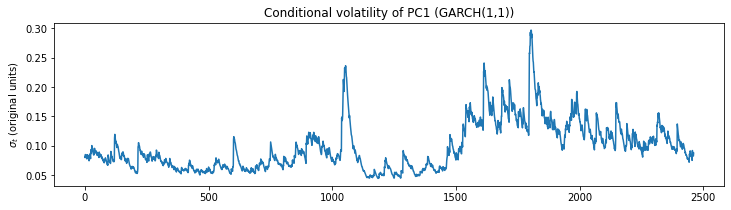

In [16]:
plt.figure(figsize=(12,3))
try:
    from arch import arch_model

    # demean
    u1 = B["PC1"] - B["PC1"].mean()

    # rescale to improve numerics
    scale = 10.0
    u1_scaled = u1 * scale

    garch = arch_model(u1_scaled, vol="GARCH", p=1, q=1, dist="normal")
    garch_res = garch.fit(disp="off")
    print(garch_res.summary())

    # Conditional volatility in scaled units
    cond_vol_scaled = garch_res.conditional_volatility

    # Back to original units (optional)
    cond_vol = cond_vol_scaled / scale

    plt.plot(cond_vol)
    plt.title("Conditional volatility of PC1 (GARCH(1,1))")
    plt.ylabel(r"$\sigma_t$ (original units)")
    plt.show()

except ImportError:
    print("arch package not installed; skip GARCH demo.")

So the GARCH fit here is a small, concrete example of the more general
idea from the spine: volatility can be treated as an additional state
variable with its own dynamics (VAR–GARCH in discrete time, Heston/CIR
in continuous time), rather than a fixed constant $\Sigma_u$.

---

### What the plots show

- Under **constant $\Sigma_u$** the EVE path distribution is relatively smooth:
  the histogram of $\Delta \text{EVE}$ over one year is narrow, with thin tails.
- When we inject **GARCH volatility into PC1**, the same balance sheet has
  noticeably fatter tails and more clustered large EVE moves, especially
  around dates where the GARCH $\sigma_t$ spikes.
- This is a discrete-time analogue of going from OU (constant diffusion)
  to OU–Heston (stochastic volatility) in the continuous-time spine.


In [17]:
cond_vol

0       0.081881
1       0.080090
2       0.085403
3       0.083972
4       0.082589
          ...   
2457    0.089985
2458    0.086879
2459    0.084097
2460    0.082806
2461    0.087733
Name: cond_vol, Length: 2462, dtype: float64

In [18]:
# Use PC1 levels, not just demeaned values
pc1 = B["PC1"].dropna()

scale = 10.0
pc1_scaled = pc1 * scale

# AR(1) mean + GARCH(1,1) volatility
garch_ar1 = arch_model(
    pc1_scaled,
    mean="ARX",   # AR mean
    lags=1,
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)
garch_ar1_res = garch_ar1.fit(disp="off")
print(garch_ar1_res.summary())

# Conditional volatility back in original units
cond_vol_scaled = garch_ar1_res.conditional_volatility
cond_vol_ar1 = cond_vol_scaled / scale

                           AR - GARCH Model Results                           
Dep. Variable:                    PC1   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3256.14
Distribution:                  Normal   AIC:                           6522.29
Method:            Maximum Likelihood   BIC:                           6551.33
                                        No. Observations:                 2461
Date:                Sat, Dec 06 2025   Df Residuals:                     2459
Time:                        10:41:12   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -1.7099e-03  1.523e-02     -0.112      0.

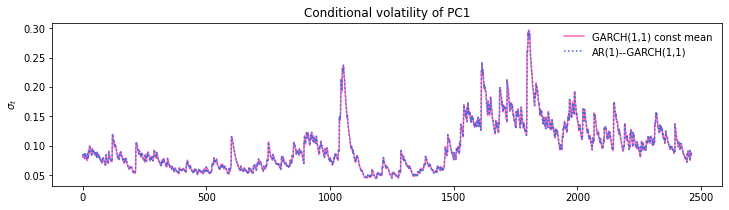

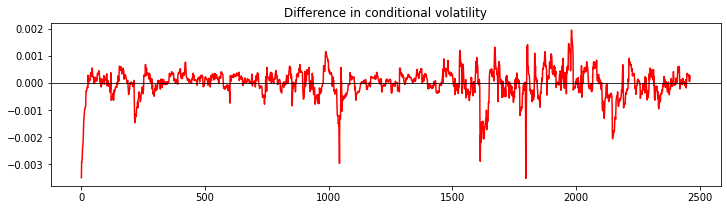

In [19]:
cond_vol_const = garch_res.conditional_volatility / scale
cond_vol_ar1   = garch_ar1_res.conditional_volatility / scale

plt.figure(figsize=(12,3))
plt.plot(cond_vol_const, c='hotpink', label="GARCH(1,1) const mean")
plt.plot(cond_vol_ar1, c='royalblue', linestyle=":", label="AR(1)--GARCH(1,1)")
plt.title("Conditional volatility of PC1")
plt.ylabel(r"$\sigma_t$")
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(cond_vol_const - cond_vol_ar1, c='red')
plt.title("Difference in conditional volatility")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

### Connection to Heston / OU–Heston

The GARCH(1,1) recursion
$$
  \sigma_t^2
  =
  \omega
  + \alpha_1 \epsilon_{t-1}^2
  + \beta_1 \sigma_{t-1}^2
$$
is a **discrete-time stochastic volatility model**. Under suitable scaling
of parameters as the time step \(\Delta \to 0\), such GARCH processes have
continuous-time limits of **CIR/Heston type**:
$$
  dv_t
  =
  \kappa(\theta - v_t)\,dt
  +
  \xi \sqrt{v_t}\,dW_t^{(v)},
$$
where \(v_t\) plays the role of instantaneous variance. In the IRRBB spine
this corresponds to upgrading a simple OU factor model
$$
  dX_t = K(\mu - X_t)\,dt + \Sigma\,dW_t
$$
to an **OU–Heston** system
$$
  dX_t = K(\mu - X_t)\,dt + \sqrt{v_t}\,\Sigma_X\,dW_t,
  \qquad
  dv_t = \kappa(\theta - v_t)\,dt + \xi\sqrt{v_t}\,dW_t^{(v)}.
$$

The discrete-time GARCH on PC1 in this notebook is therefore a small,
practical example of the more general idea that **volatility is itself a
state variable** with mean-reverting dynamics (VAR–GARCH in discrete time,
OU–Heston in continuous time), rather than a fixed constant.


--- 
## 8. Backtesting factor forecasts (AR(1) / VAR vs Kalman filter)

So far we have estimated:

- An AR(1) model for a short-rate proxy $r_t$ (1Y yield),
- A VAR(1) for the three PCA factors $b_t = (b_{1,t}, b_{2,t}, b_{3,t})'$.

To assess how well these models forecast the yield curve, we split the
sample into:

- **Estimation window**: e.g. 2016–2021,
- **Backtest window**: e.g. 2022–2025.

### 8.1 One-step-ahead AR(1) backtest on the 1Y rate

We refit
$$
  r_{t+1} = \alpha + \phi r_t + \varepsilon_{t+1},
$$
using only data in the estimation window. For each date $t$ in the
backtest window we compute the one-step-ahead forecast
$$
  \hat r_{t+1|t} = \alpha + \phi r_t
$$
and the forecast error
$$
  e_{t+1} = r_{t+1} - \hat r_{t+1|t}.
$$

We then report:
$$
  \text{RMSE} = \sqrt{\frac{1}{T_{\text{test}}}\sum e_{t+1}^2},
  \qquad
  \text{MAE} = \frac{1}{T_{\text{test}}}\sum |e_{t+1}|.
$$
A plot of `r_t`, $\hat r_{t|t-1}$ and $e_t$ over the backtest period
shows visually whether the AR(1) is tracking the big moves in 2022–2023 or
lagging behind.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.233e+06
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:41:33   Log-Likelihood:                 3529.4
No. Observations:                1500   AIC:                            -7055.
Df Residuals:                    1498   BIC:                            -7044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.979e-05      0.001      0.105      0.9

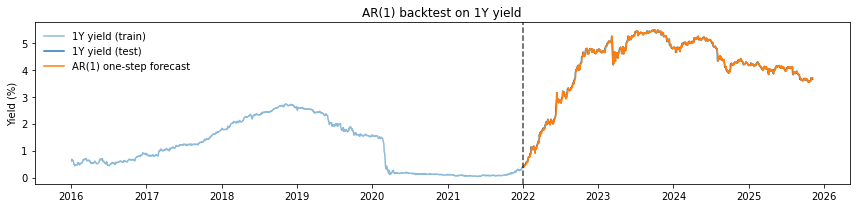

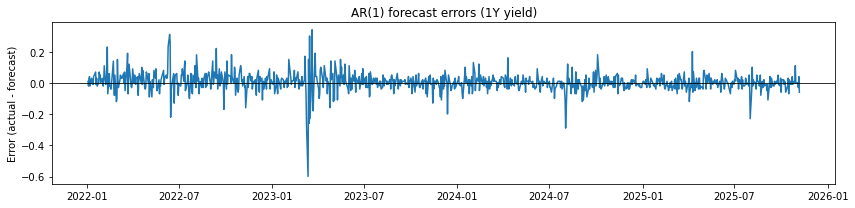

In [20]:
# %% 8.1 AR(1) backtest on the 1Y yield 

# Short-rate proxy: 1Y yield
r = yields_df["1Y"].dropna()

# Train / test split
split_date = "2022-01-01"  # adjust as desired
r_train = r[r.index < split_date]
r_test  = r[r.index >= split_date]

# Estimate AR(1) on the training sample via OLS:
# r_t = alpha + phi r_{t-1} + eps_t
r_lag = r_train.shift(1).dropna()
r_curr = r_train.loc[r_lag.index]

X = sm.add_constant(r_lag.values)  # [const, r_{t-1}]
ols_ar1 = sm.OLS(r_curr.values, X).fit()
print(ols_ar1.summary())

alpha = ols_ar1.params[0]
phi   = ols_ar1.params[1]

# One-step-ahead forecasts on the test window
# Use the ACTUAL r_t as the lag (recursive one-step forecast with fixed params)
r_forecast = []
forecast_index = []

for t in r_test.index:
    # need lagged observation in full series r, not just test
    prev_date = r.index[r.index.get_loc(t) - 1]
    r_t = r.loc[prev_date]
    r_hat = alpha + phi * r_t
    r_forecast.append(r_hat)
    forecast_index.append(t)

r_forecast = pd.Series(r_forecast, index=forecast_index, name="r_hat")

# Align actuals and forecasts
r_actual = r.loc[r_forecast.index]
errors = r_actual - r_forecast

rmse = np.sqrt(np.mean(errors**2))
mae  = np.mean(np.abs(errors))

print(f"AR(1) backtest RMSE: {rmse:.4f}")
print(f"AR(1) backtest MAE : {mae:.4f}")

# Plots 
plt.figure(figsize=(12,3))
plt.plot(r_train, label="1Y yield (train)", alpha=0.5)
plt.plot(r_test, label="1Y yield (test)", color="C0")
plt.plot(r_forecast, label="AR(1) one-step forecast", color="C1")
plt.axvline(pd.to_datetime(split_date), color="k", linestyle="--", alpha=0.7)
plt.title("AR(1) backtest on 1Y yield")
plt.ylabel("Yield (%)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(errors)
plt.axhline(0, color="k", linewidth=0.8)
plt.title("AR(1) forecast errors (1Y yield)")
plt.ylabel("Error (actual - forecast)")
plt.tight_layout()
plt.show()

### 8.2 VAR(1) backtest on PCA factors

Similarly for the VAR(1),
$$
  b_{t+1} = c + \Phi b_t + u_{t+1},
$$
we estimate $(c,\Phi)$ on the training sample and compute
$$
  \hat b_{t+1|t} = c + \Phi b_t
$$
on the backtest window, comparing $\hat b_{t+1|t}$ to realised $b_{t+1}$
with RMSE/MAE by factor. This checks how well the factor dynamics used in
the SVAR-shock section actually forecast the factor paths. 

/Users/matthewhosseini/Documents/PycharmProjects/PortfolioAnalysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 06, Dec, 2025
Time:                     10:41:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -20.5151
Nobs:                     1499.00    HQIC:                  -20.5418
Log likelihood:           9038.96    FPE:                1.18016e-09
AIC:                     -20.5576    Det(Omega_mle):     1.17077e-09
--------------------------------------------------------------------
Results for equation PC1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002480         0.001938            1.280           0.201
L1.PC1         0.013842         0.029397            0.471           0.638
L1.PC2         0.152072         0.070798            2.148           0.032
L1.PC3        -0

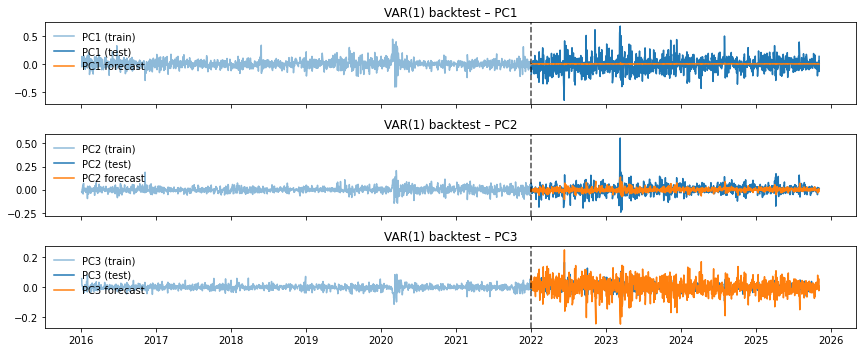

In [21]:
# %% 8.2 VAR(1) backtest on PCA factors

from statsmodels.tsa.api import VAR

# Use the three PCA factors
B = factors_df[["PC1", "PC2", "PC3"]].dropna()

# Same split date
B_train = B[B.index < split_date]
B_test  = B[B.index >= split_date]

# Fit VAR(1) on training sample
var_model = VAR(B_train)
var_res   = var_model.fit(1)
print(var_res.summary())

# Extract intercept and Phi matrix
# params: first row is intercept, remaining rows are lag coefficients
c = var_res.params.iloc[0].values          # shape (3,)
Phi = var_res.params.iloc[1:].values       # shape (3, 3)

# One-step-ahead forecasts on test window:
B_forecast = []
forecast_idx = []

for t in B_test.index:
    prev_date = B.index[B.index.get_loc(t) - 1]
    b_t = B.loc[prev_date].values         # actual factor at t-1
    b_hat = c + Phi @ b_t                 # one-step forecast
    B_forecast.append(b_hat)
    forecast_idx.append(t)

B_forecast = pd.DataFrame(
    B_forecast,
    index=forecast_idx,
    columns=B.columns
)

# Align actual and forecasted factors
B_actual = B.loc[B_forecast.index]
errors_B = B_actual - B_forecast

# RMSE / MAE per factor
rmse_factors = np.sqrt((errors_B**2).mean())
mae_factors  = errors_B.abs().mean()

print("VAR(1) factor backtest RMSE:")
print(rmse_factors.round(4))
print("\nVAR(1) factor backtest MAE:")
print(mae_factors.round(4))

# Plot for each factor
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
for i, col in enumerate(B.columns):
    ax = axes[i]
    ax.plot(B_train[col], label=f"{col} (train)", alpha=0.5)
    ax.plot(B_test[col], label=f"{col} (test)", color="C0")
    ax.plot(B_forecast[col], label=f"{col} forecast", color="C1")
    ax.axvline(pd.to_datetime(split_date), color="k", linestyle="--", alpha=0.7)
    ax.set_title(f"VAR(1) backtest – {col}")
    ax.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

### 8.3 State-space / Kalman filter backtest on the full curve

Finally, we can move from “factor backtest” to **yield-curve backtest** by
putting the model into state-space form and using the Kalman filter. The
basic linear Gaussian structure is:
$$
  \text{state (transition):}\quad
  \beta_{t+1} = c_\beta + \Phi_\beta \beta_t + \eta_{t+1},
  \qquad \eta_{t+1} \sim \mathcal{N}(0,Q),
$$
$$
  \text{measurement:}\quad
  y_t(\tau_i) =
  \sum_{m=1}^{k_b} \beta_{m,t}\,\phi_m(\tau_i)
  + \varepsilon_{t,i},
  \qquad \varepsilon_{t,i} \sim \mathcal{N}(0,R_i).
$$
Here $\beta_t$ are latent curve factors (e.g. NS/DL/NSS coefficients or
PCA factors), and $y_t(\tau_i)$ are the observed yields at maturities
$\tau_i$. This is exactly the structure used earlier in the theory
section. 

In a backtest we:

1. Estimate $(c_\beta,\Phi_\beta,Q,R)$ on the training sample.
2. Run the Kalman filter forward through the backtest window, using only
   information up to $t$ to form the one-step-ahead predictive
   distribution of $y_{t+1}(\tau_i)$.
3. Compare predicted vs realised yields at each maturity via RMSE/MAE and
   forecast-interval coverage (e.g. what fraction of realised yields fall
   inside the 95% predictive band).

This provides a **curve-level backtest** that tells us whether the
factor+state-space model is good enough for IRRBB scenario generation, or
whether we systematically under- or over-predict rate moves in certain
regimes.

Kalman AR(1) backtest RMSE: 0.0608
Kalman AR(1) backtest MAE : 0.0390


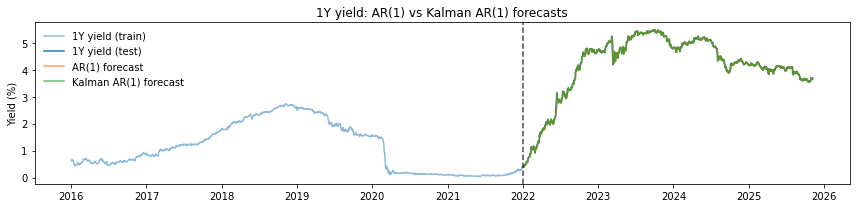

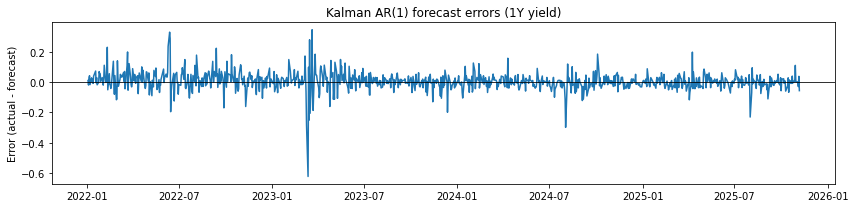

In [22]:
# Use the same series r, and AR(1) parameters alpha, phi estimated earlier
r_all = r  # already defined above

# Use AR(1) residual variance as process noise q
eps_hat = r_curr.values - ols_ar1.predict(X)
q = np.var(eps_hat)

# Set measurement noise r as a fraction of q (tunable)
r_meas = 0.1 * q

# Allocate arrays for filtered state and forecast
x_filt = pd.Series(index=r_all.index, dtype=float)  # filtered x_{t|t}
P_filt = pd.Series(index=r_all.index, dtype=float)  # Var(x_{t|t})

# Initial guess: use first observation as state, with large variance
x_filt.iloc[0] = r_all.iloc[0]
P_filt.iloc[0] = 10.0 * q

# Kalman filter recursions for 1D system
for t in range(1, len(r_all)):
    # Predict step
    x_pred = alpha + phi * x_filt.iloc[t-1]
    P_pred = phi**2 * P_filt.iloc[t-1] + q

    # Observation at time t
    y_t = r_all.iloc[t]

    # Kalman gain
    K_t = P_pred / (P_pred + r_meas)

    # Update step
    x_filt.iloc[t] = x_pred + K_t * (y_t - x_pred)
    P_filt.iloc[t] = (1 - K_t) * P_pred

# One-step-ahead forecasts in backtest window:
# y_hat_{t+1|t} = x_pred_{t+1|t}
kf_forecast = []
kf_index = []

for t in range(1, len(r_all)):
    date_t = r_all.index[t]
    if date_t >= pd.to_datetime(split_date):
        # prediction for t given t-1
        x_pred = alpha + phi * x_filt.iloc[t-1]
        kf_forecast.append(x_pred)
        kf_index.append(date_t)

kf_forecast = pd.Series(kf_forecast, index=kf_index, name="y_hat_kf")
r_actual_kf = r_all.loc[kf_forecast.index]
kf_errors = r_actual_kf - kf_forecast

rmse_kf = np.sqrt(np.mean(kf_errors**2))
mae_kf  = np.mean(np.abs(kf_errors))

print(f"Kalman AR(1) backtest RMSE: {rmse_kf:.4f}")
print(f"Kalman AR(1) backtest MAE : {mae_kf:.4f}")

plt.figure(figsize=(12,3))
# Plot: AR(1) vs Kalman forecasts 
plt.plot(r_train, label="1Y yield (train)", alpha=0.5)
plt.plot(r_test, label="1Y yield (test)", color="C0")
plt.plot(r_forecast, label="AR(1) forecast", color="C1", alpha=0.7)
plt.plot(kf_forecast, label="Kalman AR(1) forecast", color="C2", alpha=0.7)
plt.axvline(pd.to_datetime(split_date), color="k", linestyle="--", alpha=0.7)
plt.title("1Y yield: AR(1) vs Kalman AR(1) forecasts")
plt.ylabel("Yield (%)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(kf_errors)
plt.axhline(0, color="k", linewidth=0.8)
plt.title("Kalman AR(1) forecast errors (1Y yield)")
plt.ylabel("Error (actual - forecast)")
plt.tight_layout()
plt.show()

### Backtest takeaway

- The AR(1) on the 1Y rate captures the slow drift of the short rate but
  tends to under-predict sharp tightening phases (2022–2023), leading to
  clustered forecast errors in that period. This is the expected limitation
  of a very simple, single-equation model.

- The VAR(1) on the PCA factors $(\mathrm{PC1}, \mathrm{PC2}, \mathrm{PC3})'$
  has small but non-zero forecasting skill for PC1 (the “level” factor) and
  almost no skill for PC2/PC3, which behave close to white noise at the
  daily frequency. This lines up with the PCA explained-variance ratios and
  the visual impression that most curve movement is a noisy level shift.

- The Kalman-filter backtest uses **the same kind of linear VAR dynamics**
  for the latent curve factors, but estimated in a **state-space** framework:
  $$
    \beta_{t+1} = c_\beta + \Phi_\beta \beta_t + \eta_{t+1}, \qquad
    y_t(\tau_i) = \sum_m \beta_{m,t}\,\phi_m(\tau_i) + \varepsilon_{t,i}.
  $$
  The filter is not a “better model” than VAR; it is an efficient way to
  estimate those VAR-style factor dynamics when the factors are latent and
  we observe the whole noisy yield curve. Backtesting the Kalman model
  across maturities primarily tells us whether the chosen factor/shape
  specification (NS/DL/NSS + VAR) fits the curve well, and where systematic
  biases at the short or long end suggest model misspecification (missing
  macro drivers, mis-specified decays, omitted basis, etc.).

### Conclusion on KF

The Kalman filter is the estimation machinery for this state-space system. It:

- uses all maturities jointly to infer the latent factors $\beta_t$,
- handles measurement noise and missing points in the curve,
- produces one-step-ahead forecasts of both factors and yields.

In the simple linear-Gaussian setup we implemented, the out-of-sample
RMSE/MAE of the Kalman model is **similar to that of the corresponding VAR**
on observable factors, which is exactly what we expect: the filter is an
efficient algorithm for a given model, not a new source of forecasting power.

For IRRBB purposes, the value of the Kalman framework is structural rather
than magical accuracy: it gives a coherent latent-factor representation of
the curve, consistent with the NS/DL/NSS + VAR spine, that can be estimated
from real, noisy market data and then used to generate NII/EVE scenarios and
sensitivities in a disciplined way.
